In [1]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from skimage.metrics import structural_similarity as ssim
import pickle
from PIL import Image
import cv2
import sys

# Get the parent directory of the current directory
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
print(project_root)

from model.diffusion.unet import Unet, UpSample, DownSample, time_embedding
from model.diffusion.diffusion_proc import Diffusion, linear_noise_schedule
from model.diffusion.blocks import ResBlock, AttentionBlock, TimestepBlock, group_norm_layer

%matplotlib inline

c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\Anirbit\Desktop\MSc\Ind Project\Msc-Project\src


## CONVLSTM

In [2]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []

        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor):
        b, seq_len, _, h, w = input_tensor.size()
        hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], 
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

class WildfirePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(WildfirePredictor, self).__init__()
        self.convLstm = ConvLSTM(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers, return_all_layers=False)
        self.conv = nn.Conv2d(hidden_dim[-1], 1, kernel_size=1, padding=0)
        
    def forward(self, x):
        layer_output_list, last_state_list = self.convLstm(x)
        out = layer_output_list[0][:, -1, :, :, :]
        out = self.conv(out)
        
        return out

# CNN

In [3]:
class Wildfire_CNN(nn.Module):
    def __init__(self):
        super(Wildfire_CNN, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout with a 50% drop probability
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

# DIFFUSION - Classifier free guidance and Image conditioned

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
diffusion_model =  Unet(
    in_ch=1,
    cond_ch=1,
    model_ch=96,
    output_ch=1,
    channel_mult=(1, 2, 2),
    attn_res=[],
)

## EVALUATION - COMPARE DIFFUSION PERFORMANCE TO BASELINE CONVLSTM

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# baseline_model = WildfirePredictor(input_dim=1, hidden_dim=[64, 64, 64], kernel_size=[3, 3, 3], num_layers=3)
# baseline_model.load_state_dict(torch.load("C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/baseline_seq_convlstm_64x64.pt"))
# baseline_model.to(device)

baseline_model = Wildfire_CNN()
baseline_model.load_state_dict(torch.load("C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/baseline_cnn_64x64_simData1000samples.pt"))
baseline_model.to(device)

diffusion_model.load_state_dict(torch.load('C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/gde_ensemble_model_4_64x64_simData_1000samples.pt'))
diffusion_model.to(device)

# diffusion_model_reg = torch.load('C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/gde_ensemble_model_4_64x64_simData_regGuided_noDataAug.h5')
# diffusion_model_reg.to(device)

gaussian_diffusion = Diffusion(timesteps=500, noise_schedule='linear')

#### Evaluation Dataset

In [6]:
class CondSeqImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, conditional_offset=5):
        self.data_dir = data_dir
        self.transform = transform
        self.conditional_offset = conditional_offset
        self.cond_images = []
        self.target_images = []
        self._load_data()

    def _load_data(self):
        files = sorted([os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.endswith('.mpy')])
        for file in files:
            with open(file, 'rb') as f:
                images = pickle.load(f)
                if isinstance(images, list):
                    images = np.array(images)
                    
                for img_idx in range(len(images) - self.conditional_offset):
                    self.cond_images.append(images[img_idx])
                    self.target_images.append(images[img_idx + self.conditional_offset])

    def __len__(self):
        return len(self.cond_images)

    def __getitem__(self, idx):
        # collection_idx, image_idx = self._get_indices(idx)
        cond_image = self.cond_images[idx]
        image = self.target_images[idx]

        if self.transform:
            image = self.transform(image)
            cond_image = self.transform(cond_image)

        return image, cond_image


transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)), 
    # transforms.Resize(64)
])

dataset_2 = CondSeqImageDataset("C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/simulated_bin_frames", transform=transform)



# Split dataset into training and testing
train_size = int(0.8 * len(dataset_2))
test_size = len(dataset_2) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_2, [train_size, test_size])

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


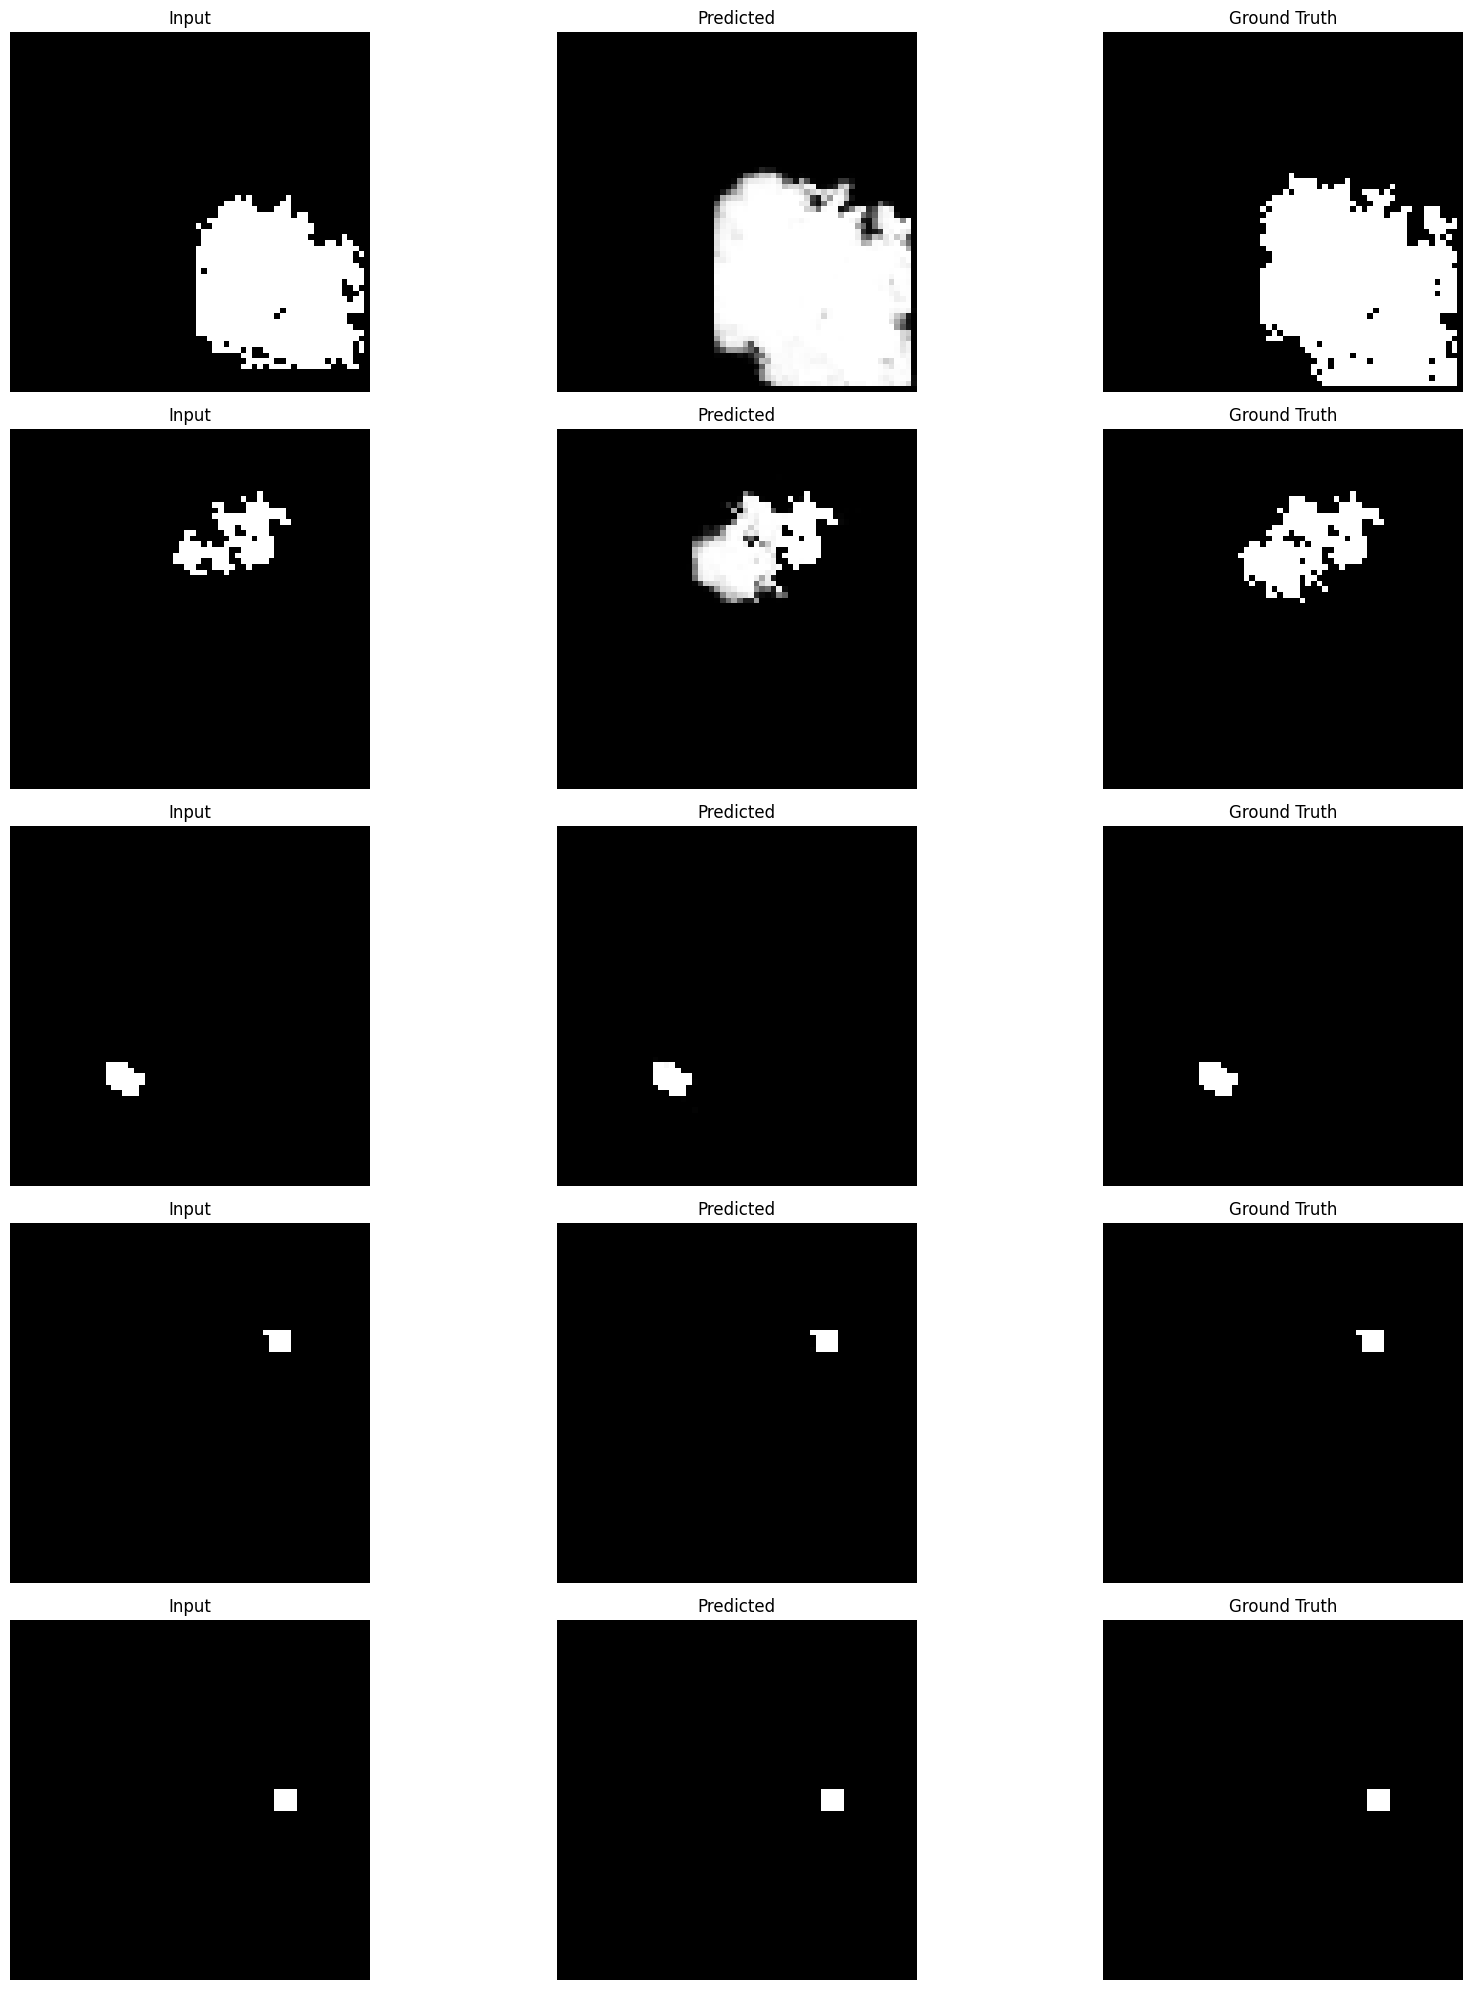

In [7]:
def generate_convlstm_predictions(model, cond_images, target_images):
    model.eval()
    predictions = []
    ground_truths = []
    inputs = []

    with torch.no_grad():
        output = model(cond_images)
        predictions.append(output.cpu())
        ground_truths.append(target_images.cpu())
        inputs.append(cond_images.cpu())

    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)
    inputs = torch.cat(inputs, dim=0)

    return predictions, ground_truths, inputs

def generate_cnn_predictions(model, cond_images, target_images):
    model.eval()
    predictions = []
    ground_truths = []
    inputs = []

    with torch.no_grad():
        output = model(cond_images)
        predictions.append(output.cpu())
        ground_truths.append(target_images.cpu())
        inputs.append(cond_images.cpu())

    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)
    inputs = torch.cat(inputs, dim=0)

    return predictions, ground_truths, inputs

def plot_cnn_predictions(predictions, ground_truths, inputs, num_images=5, save=False):
    fig, axs = plt.subplots(num_images, 3, figsize=(18, 20))
    for i in range(num_images):
        input_img = inputs[i].squeeze(0)
        axs[i, 0].imshow(input_img, cmap='gray')
        axs[i, 0].set_title(f'Input')
        axs[i, 0].axis('off')

        # Plot the predicted image
        pred_img = predictions[i].squeeze(0)
        axs[i, 1].imshow(pred_img, cmap='gray')
        axs[i, 1].set_title('Predicted')
        axs[i, 1].axis('off')

        # Plot the ground truth image
        true_img = ground_truths[i].squeeze(0)
        axs[i, 2].imshow(true_img, cmap='gray')
        axs[i, 2].set_title('Ground Truth')
        axs[i, 2].axis('off')

    plt.tight_layout()
    if save:
        plt.savefig("lstm_output.png", dpi=300)
    plt.show()

def plot_lstm_predictions(predictions, ground_truths, inputs, num_images=5, save=False):
    fig, axs = plt.subplots(num_images, 6, figsize=(18, 20))
    for i in range(num_images):
        # Plot the 4 input images
        for j in range(4):
            input_img = inputs[i, j].squeeze(0)
            axs[i, j].imshow(input_img, cmap='gray')
            axs[i, j].set_title(f'Input {j+1}')
            axs[i, j].axis('off')

        # Plot the predicted image
        pred_img = predictions[i].squeeze(0)
        axs[i, 4].imshow(pred_img, cmap='gray')
        axs[i, 4].set_title('Predicted')
        axs[i, 4].axis('off')

        # Plot the ground truth image
        true_img = ground_truths[i].squeeze(0)
        axs[i, 5].imshow(true_img, cmap='gray')
        axs[i, 5].set_title('Ground Truth')
        axs[i, 5].axis('off')

    plt.tight_layout()
    if save:
        plt.savefig("lstm_output.png", dpi=300)
    plt.show()


data_iter = iter(test_loader)
target_img, cond_img = next(data_iter)

# Ensure images are on the correct device and of type float32
target_img = target_img.to(device).float()
cond_img = cond_img.to(device).float()

preds, ground_truths, inputs = generate_cnn_predictions(baseline_model, cond_img, target_img)
plot_cnn_predictions(preds, ground_truths, inputs, save=False)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing

def adaptive_threshold(image, sigma=1.0, morph_size=3):
    # Normalize image to range [0, 1] from [-1, 1]
    normalized_image = (image + 1) / 2.0
    
    # Apply Gaussian filter to smooth the image (optional, helps with noise)
    smoothed_image = gaussian_filter(normalized_image, sigma=sigma)
    
    # Flatten the smoothed image
    pixel_values = smoothed_image.flatten().reshape(-1, 1)
    
    # Perform K-means clustering with 2 clusters
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(pixel_values)
    labels = kmeans.labels_
    
    # Determine which cluster is the light region
    cluster_means = kmeans.cluster_centers_.flatten()
    light_cluster = np.argmax(cluster_means)
    
    # Create a binary image based on the cluster labels
    binary_image = np.where(labels == light_cluster, 1, 0)
    binary_image = binary_image.reshape(normalized_image.shape)
    
    # Perform morphological operations to refine the regions
    binary_image = binary_opening(binary_image, structure=np.ones((morph_size, morph_size)))
    binary_image = binary_closing(binary_image, structure=np.ones((morph_size, morph_size)))
    
    return binary_image

In [15]:
def mean_prediction(pred_arr):
    imgs = np.array(pred_arr)
    avg = np.mean(imgs, axis=0)
    
    return avg

# Define the image size and channels (modify as per your requirements)
image_size = target_img.shape[-1]
channels = target_img.shape[1]

# Call the sample method
generated_image_arr = []
for idx in range(10):
    generated_images = gaussian_diffusion.sample(
        model=diffusion_model,
        image_size=image_size,
        cond_img=cond_img,
        batch_size=32,  # Set the desired batch size
        channels=channels,
        w=2,
        clip_denoised=True
    )
    generated_image_arr.append(generated_images[-1].squeeze())

mean_preds = mean_prediction(generated_image_arr)

grid_size = int(np.ceil(np.sqrt(mean_preds.shape[0])))

# Plot the images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Remove axis for each subplot
for ax in axes.flatten():
    ax.axis('off')

# Plot each image
for i, ax in enumerate(axes.flatten()):
    if i < mean_preds.shape[0]:
        ax.imshow(adaptive_threshold(mean_preds[i], sigma=0.9, morph_size=3), cmap='gray')

plt.tight_layout()
plt.show()

sampling loop time step:  45%|████▍     | 223/500 [02:23<02:57,  1.56it/s]


KeyboardInterrupt: 

In [12]:
diffusion_outputs = generated_images[-1]
cnnAE_outputs = preds.numpy()

expected_outputs = ground_truths.numpy()

print(diffusion_outputs.shape, cnnAE_outputs.shape, expected_outputs.shape)

(32, 1, 64, 64) (32, 1, 64, 64) (32, 1, 64, 64)


### Reconstruction error - MSE and MAE

In [13]:
def calculate_errors(original_images, reconstructed_images):
    mse = mean_squared_error(original_images.flatten(), reconstructed_images.flatten())
    mae = mean_absolute_error(original_images.flatten(), reconstructed_images.flatten())
    return mse, mae

mse_diffusion, mae_diffusion = calculate_errors(expected_outputs, diffusion_outputs)
mse_cnnAE, mae_cnnAE = calculate_errors(expected_outputs, cnnAE_outputs)

print(f"Reconstruction error diffusion outputs - MSE: {mse_diffusion} | MAE: {mae_diffusion}")
print(f"Reconstruction error CNN outputs - MSE: {mse_cnnAE} | MAE: {mae_cnnAE}")


Reconstruction error diffusion outputs - MSE: 0.013637264259159565 | MAE: 0.017470767721533775
Reconstruction error CNN outputs - MSE: 0.005814420524984598 | MAE: 0.009112765081226826


### Frechet Inception Distance

In [45]:
def preprocess_images(images):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((299, 299)),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    images = np.squeeze(images, axis=1)  # Remove the single channel dimension
    return torch.stack([transform(img) for img in images])

def get_inception_features(images, model, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        features = model(images)
    return features.cpu().numpy()

def calculate_fid(real_images, generated_images, device):
    # Load pre-trained InceptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.fc = torch.nn.Identity()  # Remove the final classification layer

    # Preprocess images
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    # Get InceptionV3 features
    real_features = get_inception_features(real_images, model, device)
    generated_features = get_inception_features(generated_images, model, device)

    # Calculate mean and covariance matrices
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID
    ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    
    # Numerical error might give slight imaginary component, discard if exists
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"FID diffusion outputs =  {calculate_fid(expected_outputs, diffusion_outputs, device)}")
print(f"FID CNN outputs  =  {calculate_fid(expected_outputs, cnnAE_outputs, device)}")


FID diffusion outputs =  202.80608337136357
FID CNN outputs  =  69.47160314097974


### SSIM 

In [14]:
def calculate_ssim(original_images, reconstructed_images, win_size=5):
    """
    Calculate the mean SSIM between original and reconstructed images.

    Parameters:
    - original_images: numpy array of original images, shape (N, 64, 64)
    - reconstructed_images: numpy array of reconstructed images, shape (N, 64, 64)
    - win_size: int, optional. The side-length of the sliding window. Default is 5.

    Returns:
    - mean_ssim: float. Mean SSIM value over all image pairs.
    """
    # Ensure the images are 2D (remove single channel dimension if present)
    if original_images.shape[1] == 1:
        original_images = np.squeeze(original_images, axis=1)
    if reconstructed_images.shape[1] == 1:
        reconstructed_images = np.squeeze(reconstructed_images, axis=1)
    
    # Calculate data range from the input images
    data_range = original_images.max() - original_images.min()

    ssim_values = [ssim(orig, recon, win_size=win_size, data_range=data_range) for orig, recon in zip(original_images, reconstructed_images)]
    return np.mean(ssim_values)

print(f"SSIM diffusion outputs =  {calculate_ssim(expected_outputs, diffusion_outputs)}")
print(f"SSIM CNN outputs  =  {calculate_ssim(expected_outputs, cnnAE_outputs)}")

SSIM diffusion outputs =  0.8541547717210788
SSIM CNN outputs  =  0.9558447600948454
